# LocusRegression Simulation Studies

This tutorial covers how to construct synthetic datasets, then train and evaluate LocusRegression models using those datasets. First, some imports: 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

### Transition matrix

To simulate some data according to the generative model proposed by LocusRegression, we first need to define ground-truth genomic states for each locus in a hypothetical genome. We assign states by sampling a chain from a predefined Markov transition matrix. The transition matrix should be of size $(N_{states}, N_{states})$, and have rowsums of 1.

In [4]:
transition_matrix = np.array([
    [0.99, 0.005, 0.005],
    [0.0, 0.97, 0.03],
    [0.015, 0.015, 0.97]
])

Each of these states will correspond with changes to some simluated genomic correlate. Next we define the distribution of each correlate. Correlates are simulated using the model:

$X_{s,\ell} \sim \textrm{Normal}(\mu \cdot \delta({\textrm{state}(\ell) - s)}, \sigma^2)$

where the correlate associated with state $s$ is centered at $\mu$ for loci in that state, and $0$ otherwise. These correlates are stardardized before modeling. We provide a matrix of $\mu$'s and $\sigma$'s, each with shape $(N_{states})$.

In [5]:
signal_means = np.array([1.,1.,1.])
signal_stds = np.array([0.3, 0.25, 0.5])

### Trinucleotide differences

To finish setting up the properties of each genomic state, we define state-specific priors over the trinucleotide content of loci in that state. The trinucleotide content of each locus is subsequently sampled from a Dirichlet distribution with the corresponding prior. The priors matrix must be of shape $(N_{states}, 32)$. Here, I provide uniform priors for each state with varying degrees of noise/sparsity:

In [6]:
trinuc_priors = np.array([
    np.ones(32) * 5.,
    np.ones(32) * 20,
    np.ones(32) * 10,
])

### $\beta$ matrix

Lastly, we need to relate those states and correlates to processes. For this, we define a $\beta$ matrix of size $(N_{processes}, N_{states})$, which relates how each process associates with genomic correlates:

In [7]:
beta_matrix = np.array([
    [1,-0.5,0],
    [-0.5,1,-0.5],
    [-0.5,-0.5,1],
    [1,-1,1],
    [0.,1.,1],
])

### Generating a simulated dataset

Now, we can use these generative parameters to construct a dataset. We provide the structured information outline above, along with parameters for:

* `n_cells` : the number of samples (called "cells" here in homage to ssDNA-seq)
* `log_mean_mutations`, `log_std_mutations`: parameters of the $\mathrm{LogNormal}$ distribution from which the number of mutations per cells are drawn
* `pi_prior` : prior for the dirichlet distribution from which compositions over processes are drawn for each cell
* `n_loci` : the number of genomic bins. 10Kb bins over the entire genome gives ~250K regions after filtering repetitive elements, centromeres, etc.
* `seed` : reproducably produces the same simulated dataset

And finally, we associate each process with a known signature from the COSMIC catalogue:

In [14]:
simulation_params = dict(
    state_transition_matrix = transition_matrix,
    beta_matrix = beta_matrix,
    trinucleotide_priors = trinuc_priors,
    signal_means= signal_means,
    n_cells = 100,
    log_mean_mutations = 6,
    log_std_mutations = 0.5, 
    pi_prior = 1,
    n_loci = 250000,
    seed = 10,
    cosmic_sigs=['SBS1','SBS93','SBS3','SBS5','SBS2'],
    corpus_name='corpus1',
)

Save this configuration dictionary as a pickle file:

In [15]:
import pickle

with open('data/simulation_params.pkl','wb') as f:
    pickle.dump(simulation_params, f)

Then run the `locusregression` command to sample a synthetic dataset.

In [16]:
!locusregression simulate --config data/simulation_params.pkl --prefix "data/tutorial."

Generating samples: 100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


The simulation method outputs the same "corpus" object which is used for real data, so we can treat real and simulated data exactly the same. Additionally, the simulation outputs `parameters`, which are the ground truth attributes of the dataset which governed the generative process.

## Modeling the dataset

You can either tune a model (most realistic):

In [23]:
!locusregression create-study \
    --corpuses data/tutorial.corpus.h5 \
    -min 3 -max 10 --tune-subsample \
    --study-name tutorial.1

[I 2023-10-29 16:28:46,101] Using an existing study with name 'tutorial.1' instead of creating a new one.


In [25]:
!for i in {1..10}; do locusregression run-trial tutorial.1 -i 20 > data/$i.log 2>&1 &; done

or just provide the number of topics and get started:

In [60]:
!locusregression train-model \
                 --corpuses data/tutorial.corpus.h5 \
                 --n-components=5 \
                 -o data/tutorial_model_no-tuning.pkl

INFO:LocusRegressor:  Epoch 20  complete. | Elapsed time: 0.69 seconds. | Bound: -542245.57, improvement: 1953.57    
INFO:LocusRegressor:  Epoch 30  complete. | Elapsed time: 0.63 seconds. | Bound: -542005.79, improvement: 239.78     
INFO:LocusRegressor:  Epoch 40  complete. | Elapsed time: 0.63 seconds. | Bound: -541920.05, improvement: 85.74      
INFO:LocusRegressor:  Epoch 50  complete. | Elapsed time: 0.64 seconds. | Bound: -541904.72, improvement: 15.33      
INFO:LocusRegressor:  Epoch 60  complete. | Elapsed time: 0.67 seconds. | Bound: -541873.90, improvement: 30.82      
INFO:LocusRegressor:  Epoch 70  complete. | Elapsed time: 0.70 seconds. | Bound: -541858.66, improvement: 15.23      
INFO:LocusRegressor:  Epoch 80  complete. | Elapsed time: 0.65 seconds. | Bound: -541847.62, improvement: 11.05      
INFO:LocusRegressor:  Epoch 90  complete. | Elapsed time: 0.64 seconds. | Bound: -541847.07, improvement: 0.55       
INFO:LocusRegressor:  Epoch 100 complete. | Elapsed time

If you went with the tuning option, study and plot the model scores versus the number of topics used:

In [3]:
from optuna.visualization.matplotlib import *
from locusregression import load_study
from IPython.display import Image

study, dataset, study_attrs = load_study('tutorial.1')

/Users/allenwlynch/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Slice Plot'}, xlabel='n_components', ylabel='Objective Value'>

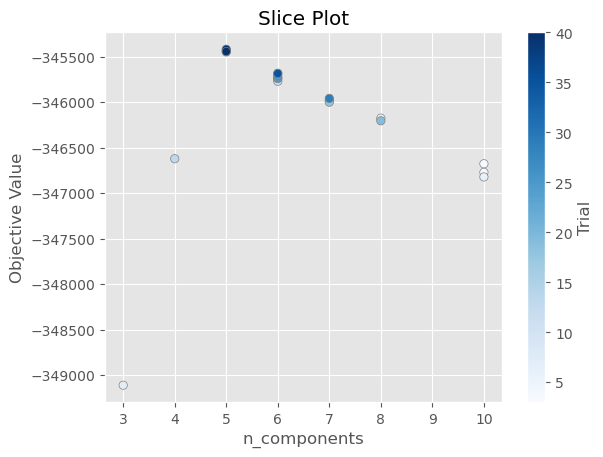

In [2]:
plot_slice(study, params = ['n_components'])

The best model had five topics, just like the simulation! The next command retrains a model on the whole dataset with the best hyperparameters found in the tuning stage. Instead of retraining the best model (by default), you can provide the trial number of a model you wish to train instead.

In [32]:
!locusregression retrain tutorial.1 -o data/tutorial_model.pkl

Training model with params:
	n_components: 5
	locus_subsample: 0.125
	seed: 95237200
	tau: 1
	kappa: 0.7
	batch_size: 70
INFO:LocusRegressor:  Epoch 40  complete. | Elapsed time: 0.47 seconds. | Bound: -543212.25, improvement: 3196.33    
INFO:LocusRegressor:  Epoch 60  complete. | Elapsed time: 0.47 seconds. | Bound: -542412.70, improvement: 799.55     
INFO:LocusRegressor:  Epoch 80  complete. | Elapsed time: 0.52 seconds. | Bound: -542145.87, improvement: 266.83     
INFO:LocusRegressor:  Epoch 100 complete. | Elapsed time: 0.49 seconds. | Bound: -542026.64, improvement: 119.23     
INFO:LocusRegressor:  Epoch 120 complete. | Elapsed time: 0.49 seconds. | Bound: -541961.65, improvement: 64.99      
INFO:LocusRegressor:  Epoch 140 complete. | Elapsed time: 0.57 seconds. | Bound: -541921.87, improvement: 39.78      
INFO:LocusRegressor:  Epoch 160 complete. | Elapsed time: 0.52 seconds. | Bound: -541894.85, improvement: 27.01      
INFO:LocusRegressor:  Epoch 180 complete. | Elapsed t

# Evaluation

I have some crude metrics implemented for evaluating the solution against the generative parameters. `coef_l1_distance` evaluates the mean $\mathrm{L1}$ distance between the the model's inferred $\beta$'s and the closest match with amongst the ground truth $\beta$'s. Next, the `signature_cosine_sim` is the average cosine similarity between each signature found by the model and the closest match signature in the ground thruth:

In [43]:
!locusregression eval-sim --model data/tutorial_model.pkl -sim data/tutorial.generative_params.pkl

coef_L1_dist	signature_cos_sim
0.08843849701647612	0.996320025870524


This model is very close to perfect. We can access important information from the trained model using the following series of commands.
First, to get the per-sample exposures to each component, use "model-predict", which saves a csv file with sample vcf filepaths and their normalized exposure to each component:

In [29]:
!locusregression model-predict data/tutorial_model.pkl \
                        -d data/tutorial.corpus.h5 \
                        > data/tutorial.predictions.csv
!head -n3 data/tutorial.predictions.csv

,Component 0,Component 1,Component 2,Component 3,Component 4
0,0.30069280253600184,0.47184855580497875,0.03721007756334462,0.11697302132840792,0.07327554276726678
1,0.12299368849495783,0.09825385839102703,0.2812218489368849,0.04511279990053025,0.4524178042766001


The next command, "model-summary", plots the association weights and signatures of each component:

In [6]:
!locusregression model-plot-summary data/tutorial_model.pkl -o data/model_summary.png

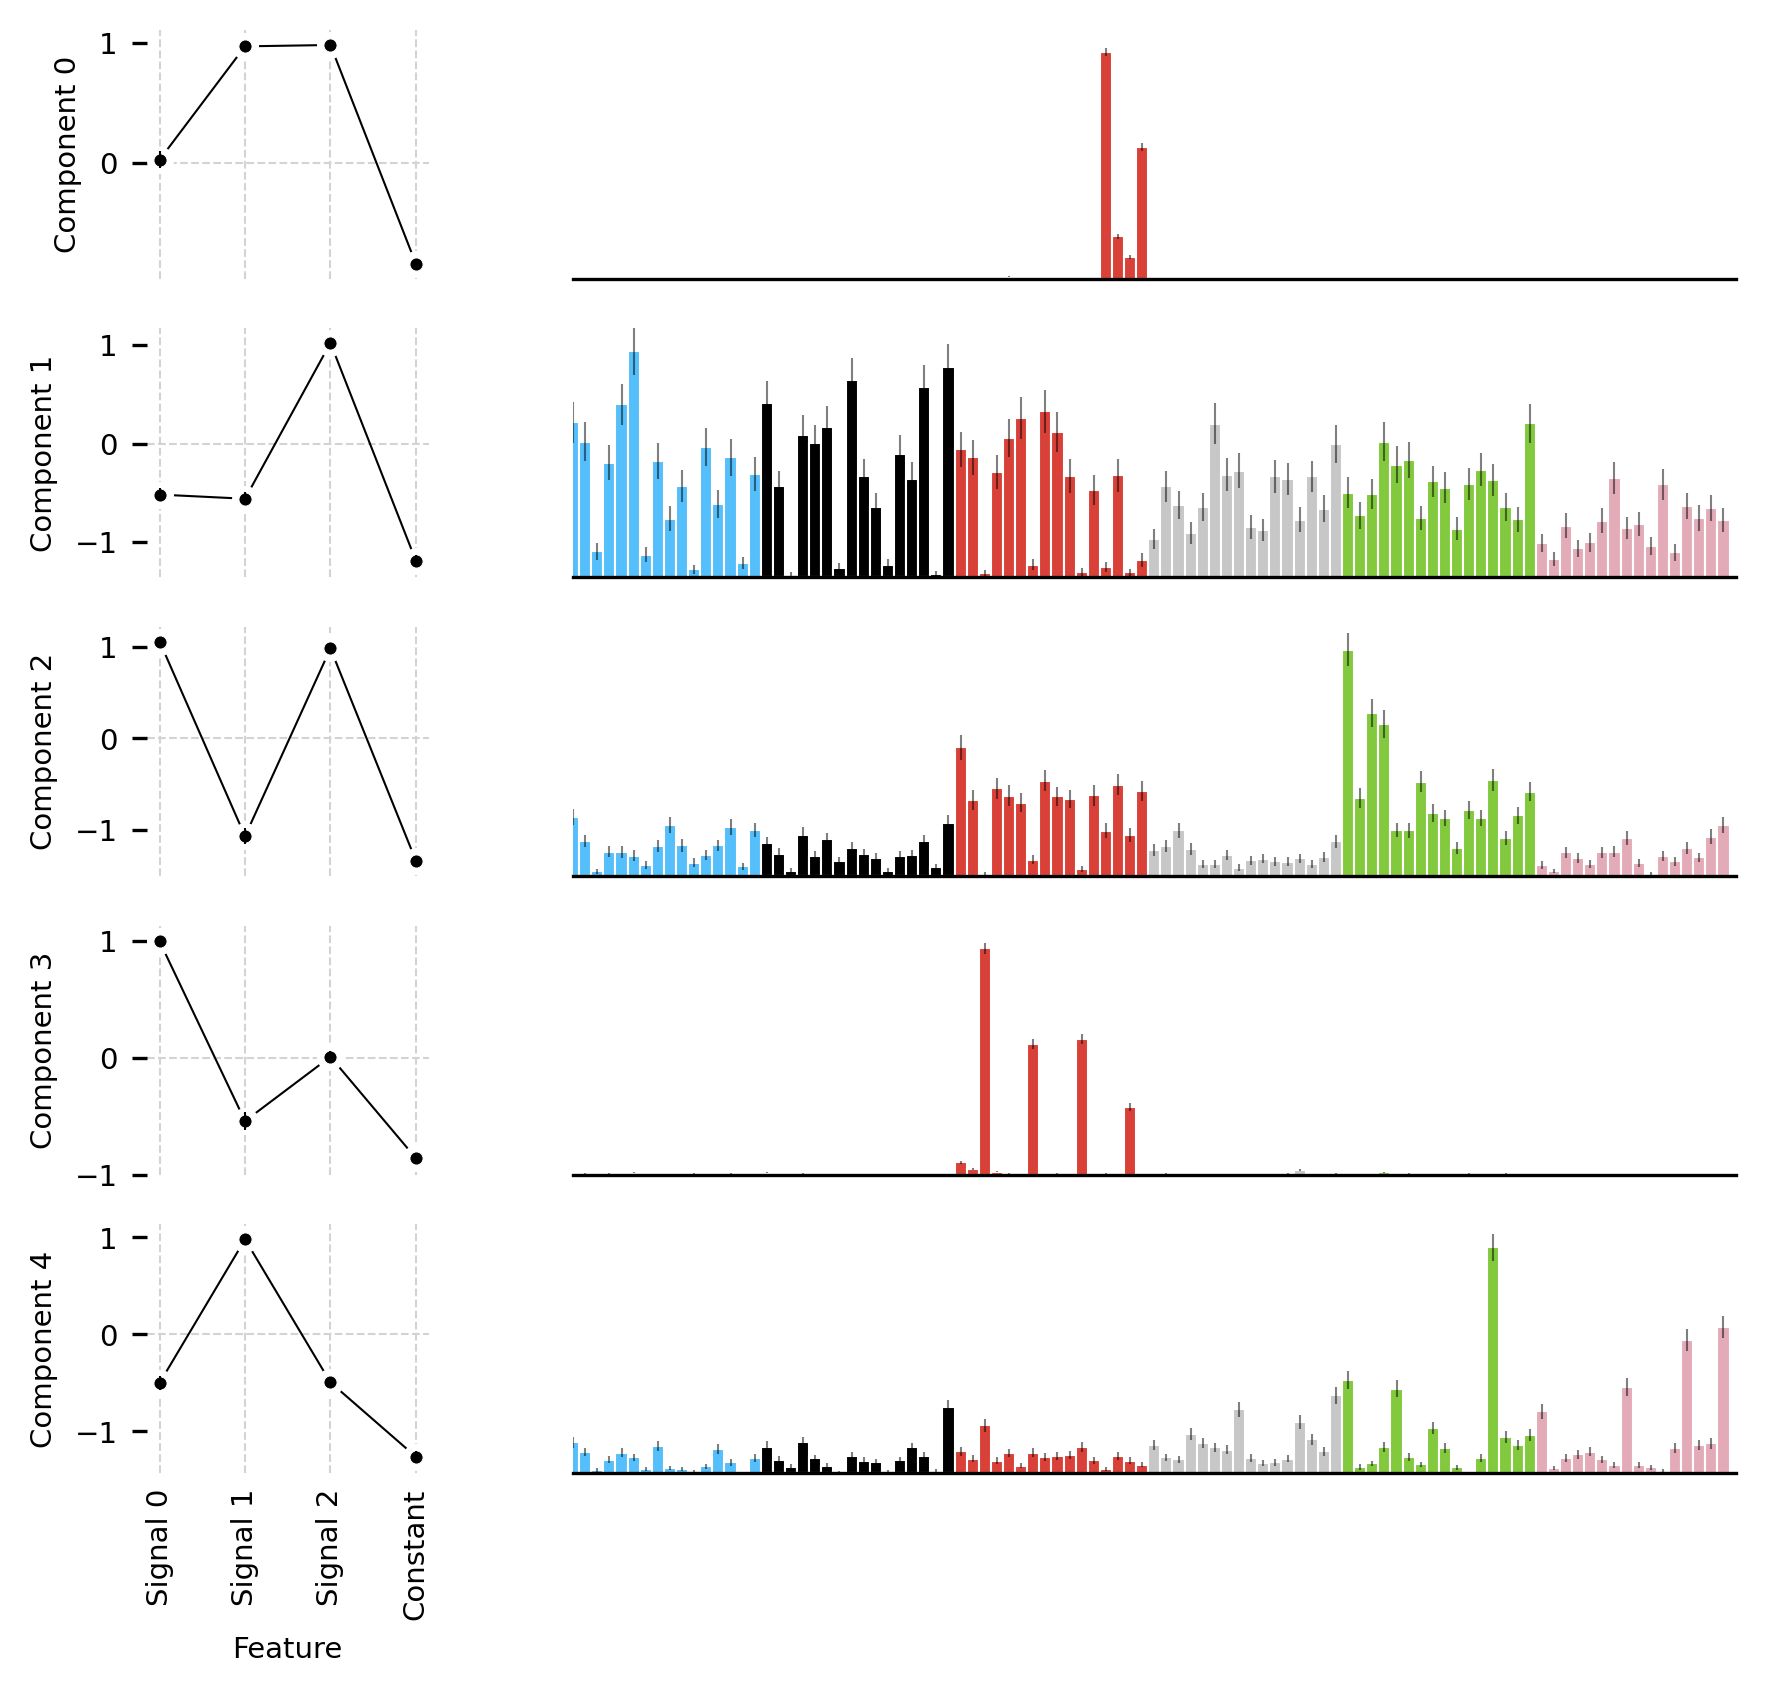

In [7]:
Image(filename='data/model_summary.png', width = 700)

"model-compare-coefs" clusters and plots a multidimensional comparison of all of the associations for each component. Try different values of "--cluster-distance/-dist" to control cluster coarseness. I find that many signatures have similar associations, so outliers are more interesting. By default, this plot colors the most common cluster grey so that outliers can be easily distinguished. 

In [11]:
!locusregression model-plot-coefs  data/tutorial_model.pkl \
                    -o data/model_compare_coefs.png \
                    -dist 1.5

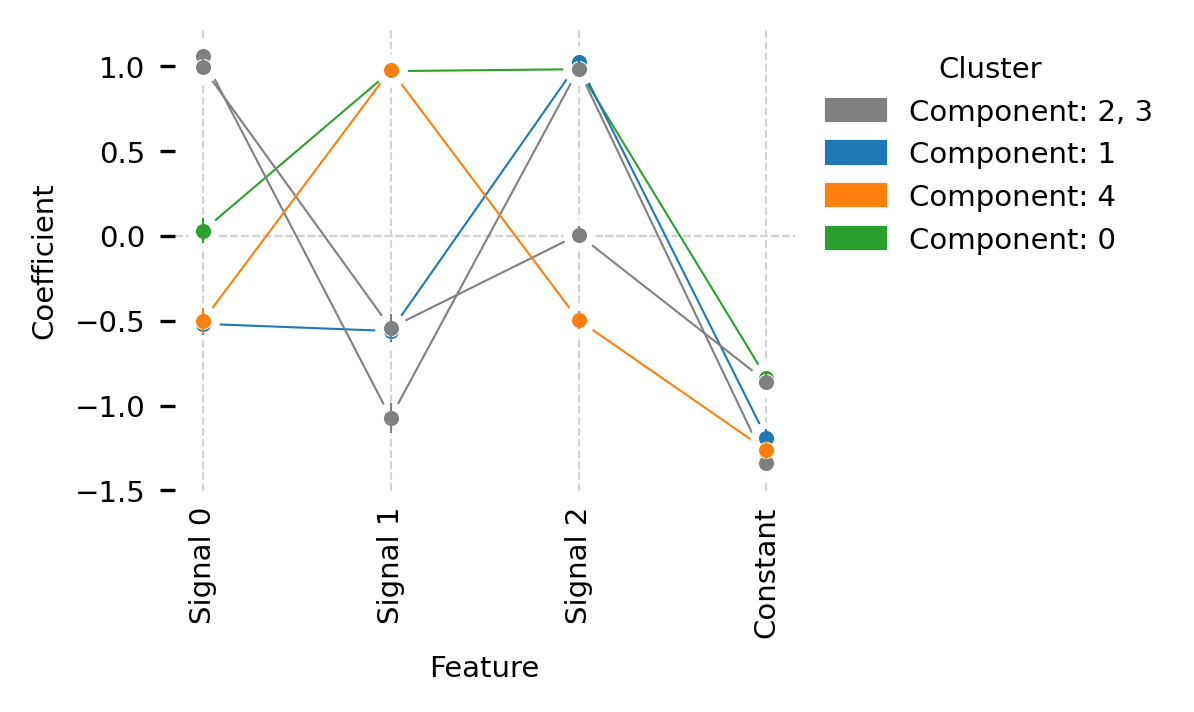

In [12]:
Image(filename='data/model_compare_coefs.png', width = 650)

In [67]:
!locusregression model-save-signatures data/tutorial_model.pkl -o data/tutorial_model_signatures.csv
!locusregression model-save-associations data/tutorial_model.pkl -o data/tutorial_model_associations.csv